<a href="https://colab.research.google.com/github/ZachPetroff/Babybot/blob/master/Expectation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class Mobile:
  def __init__(self, average_window=.5):
    self.moving = False # the mobile moving either moving or not moving 
    self.reward_window = 0 # The period of time the mobile has left to move
    self.average_window = average_window # The amount of time possible for the mobile to move
    self.moves = [] # a list of one's and zero's, describing mobile movements over time

  # causes the mobile to move, and sets the period of time it moves for 
  def create_window(self):
    self.reward_window = np.random.exponential(self.average_window)
    self.moving = True
  
  # Decreases the window as time progresses, or if the reward window is at zero, causes the mobile to stop moving
  def decrease_window(self, dt):
    if self.moving:
      self.reward_window -= dt
      if self.reward_window <= 0:
        self.reward_window = 0
        self.moving = False

class Babybot:
  def __init__(self, rates=[20, 20, 20, 20], reward=.06, punishment=.06, expectation_growth=6e-9,
      expectation_decay=1.5, connected=False, connected_limb="right arm", timestep=1/60,
      non_contigent=False, nc_rate=.8, mobile_on=True, mobile_window=0.025):
    self.rates = rates # rates per minute of each limb moving
    self.reward = reward # boost in rate per minute for each rewarded movement
    self.punishment = punishment # removal of rate per minute for each non-rewarded movement
    self.expectation = [0, 0, 0, 0] # subtracted from both reward and punishment
    self.expectation_growth = expectation_growth # growth of expectation for each rewarded movement
    self.expectation_decay = expectation_decay # decay of expectation for each non-rewarded movement
    self.connected = False
    self.limbs = ['right arm', 'left arm', 'right leg', 'left leg']
    self.connected_limb = self.limbs.index(connected_limb)
    self.move_counter = [0, 0, 0, 0] # number of moves that actually occurred per minute
    self.timestep = timestep # timestep size in minutes
   
    self.non_contigent = non_contigent # Determines whether the extinction period will have a non-contingent reward
    self.nc_rate = nc_rate # If the extinction has an non-contingent reward, this sets the rate of that non-contingent reward
    
    self.mobile_on = mobile_on # Determines whether the actions of the mobile will be taken into account
    self.mobile = Mobile(mobile_window) # An object created from the mobile class
    self.rates_moving = list(rates) # If the mobile dynamics are included, this keeps track of the rates while the mobile is moving
    
  def update_ranges(self, moves):
    # if the limb is connected, a reward is given and expectation for a reward grows
    if (self.connected and moves[self.connected_limb] and not self.mobile.moving) \
      or (self.non_contigent and np.random.random() < self.nc_rate  # if the extinction period is non contingent
          and not self.connected and (self.expectation > 0).any()): # reward state
      for limb in range(len(self.limbs)):
        # creates the peaking effect shown in data, the movements peak around 35 and then decrease to around 30 (fatigue, boredom)
        self.rates[limb] += (self.reward - self.expectation[limb]) * moves[limb]  # increases rates if reward > expectation, decreases otherwise
        
        self.expectation[limb] += self.expectation_growth * moves[limb]  
        
        self.rates = np.clip(self.rates, 0 , 45)  # sets a minimum of 0 and a maximum of 45 for the rates
        
      if self.mobile_on == True:
        self.mobile.create_window()  #  when the connected limb moves, this causes the mobile to move
            
    elif self.mobile.moving:
      for limb in range(len(self.limbs)):
          self.rates_moving[limb] -= (self.punishment - self.expectation[limb]) * moves[limb] 
          self.expectation[limb] -= self.expectation_decay * moves[limb] # creates decrease in movement at the end of the disconnected state
          if self.expectation[limb] < 0: self.expectation[limb] = 0  # the expectation can never be negative
        
    else: # disconnected
      # the expectation for a reward will increase movement when reward is not given (frustration)
      for limb in range(len(self.limbs)):
          self.rates[limb] -= (self.punishment - self.expectation[limb]) * moves[limb]
          self.expectation[limb] -= self.expectation_decay * moves[limb] # creates decrease in movement at the end of the disconnected state
          if self.expectation[limb] < 0: self.expectation[limb] = 0

  def move(self):
    if self.mobile_on == True:
        self.mobile.decrease_window(self.timestep)  # decreases while mobile is moving, until the mobile eventually comes to a halt
    moves = [] # contains which limbs should be updated
    for limb in range(len(self.limbs)):
      if self.mobile.moving:
          rate_per_timestep = self.timestep * self.rates_moving[limb]  # if the mobile is moving, the moving rates are taken into account
      else:
          rate_per_timestep = self.timestep * self.rates[limb]
      # safe to perform Bernoulli approximation
      if rate_per_timestep < .1:
        r = np.random.random()
        if r < rate_per_timestep:
          move = 1
        else:
          move = 0
      # it is reasonably possible that >1 movement will occur
      else:
        move = np.random.poisson(rate_per_timestep)
      moves.append(move)
    self.update_ranges(moves)
    return moves

  def one_cycle(self, n_minutes=25, connected=[False]*4+[True]*16+[False]*5):
    r_arm_moves = []
    l_arm_moves = []
    r_leg_moves = []
    l_leg_moves = []

    r_arm_expectations = []
    l_arm_expectations = []
    r_leg_expectations = []
    l_leg_expectations = []
    
    connected_moves = []  # moves per second of the connected limb
    
    nr = []  # non-moving rates per minute
    mr = []  # moving rates per minute

    mins = []
    steps_per_min = int(1/self.timestep)
    for min in range(n_minutes):
      self.move_counter = [0, 0, 0, 0]
      self.connected = connected[min]
      nr.append(self.rates[self.connected_limb])
      mr.append(self.rates_moving[self.connected_limb])
      for step in range(steps_per_min):
        moves = self.move()
        connected_moves.append(moves[self.connected_limb])
        
        if self.mobile.moving:           # updates mobile moves: 1 = moving, 0 = not moving
            self.mobile.moves.append(1)
        else:
            self.mobile.moves.append(0)
            
        for limb in range(len(moves)):
          self.move_counter[limb] += moves[limb]
      mins.append(min)
      r_arm_moves.append(self.move_counter[0])
      l_arm_moves.append(self.move_counter[1])
      r_leg_moves.append(self.move_counter[2])
      l_leg_moves.append(self.move_counter[3])

      r_arm_expectations.append(self.expectation[0])
      l_arm_expectations.append(self.expectation[1])
      r_leg_expectations.append(self.expectation[2])
      l_leg_expectations.append(self.expectation[3])

     
    return r_arm_moves, l_arm_moves, r_leg_moves, l_leg_moves, r_arm_expectations, l_arm_expectations, r_leg_expectations, l_leg_expectations, mins, connected_moves, self.mobile.moves, nr, mr
        

In [ ]:
num_infants = 100
connection = np.array([False]*10+[True]*30+[False]*20)  # connection for each minute
n_minutes = len(connection)
timestep = 1/120 # 1 / the number of steps per minute

reward = .06 #@param

punishment= .0075 #@param

expectation_growth= 1e-4 #@param

expectation_decay= 3e-4 #@param

connection_labels = []
prev_connection = False
counter = 0
for c in range(len(connection)):
    if prev_connection == connection[c]:
        counter += 1
    else:
        if len(connection_labels) < 1:
            connection_labels.append(counter/2)
        else:
            connection_labels.append(counter/2 + connection_labels[-1]*2)
        counter = 0
        prev_connection = connection[c]

# limb movements
ram_mean = np.zeros((n_minutes,))
lam_mean = np.zeros((n_minutes,))
rlm_mean = np.zeros((n_minutes,))
llm_mean = np.zeros((n_minutes,))

# limb expectations
rae_mean = np.zeros((n_minutes,))
lae_mean = np.zeros((n_minutes,))
rle_mean = np.zeros((n_minutes,))
lle_mean = np.zeros((n_minutes,))

for infant in range(num_infants):
      babybot = Babybot(rates=[20, 20, 20, 20],reward=reward,punishment=punishment,expectation_growth=expectation_growth,expectation_decay=expectation_decay, timestep=timestep, mobile_on=False)

      ram, lam, rlm, llm, rae, lae, rle, lle, mins, cms, mms, nr, mr = babybot.one_cycle(n_minutes, connection)
      ram_mean += ram
      lam_mean += lam
      rlm_mean += rlm
      llm_mean += llm

      rae_mean += rae
      lae_mean += lae
      rle_mean += rle
      lle_mean += lle
      
ram_mean = ram_mean / num_infants
lam_mean = lam_mean / num_infants
rlm_mean = rlm_mean / num_infants
llm_mean = llm_mean / num_infants

rae_mean = rae_mean / num_infants
lae_mean = lae_mean / num_infants
rle_mean = rle_mean / num_infants
lle_mean = lle_mean / num_infants

max_connected = max(ram_mean[connection])
max_disconnected = max(ram_mean[np.logical_not(connection)])

print("Maximum movements while connected: ", max_connected)
print("Maximum movements while disconnected: ", max_disconnected)

connection_changes = np.where(connection[1:]^connection[:-1])[0]

seperations = [0]

if len(connection_changes) > 2:
    for change in range(len(connection_changes)):
        if change % 2 == 0 and change != 0:
            seperations.append(int(connection_changes[change] - ((connection_changes[change] - connection_changes[change-1])/2)))

seperations.append(len(connection))

Maximum movements while connected:  37.27
Maximum movements while disconnected:  44.4


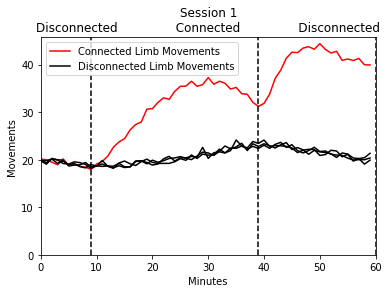

In [ ]:
# plot list of mean movements of each limb
for seperation in range(len(seperations)):
    if seperation != 0:
        plt.plot(mins[seperations[seperation-1]:seperations[seperation]], ram_mean[seperations[seperation-1]:seperations[seperation]], 'red', label="Connected Limb Movements")
        plt.plot(mins[seperations[seperation-1]:seperations[seperation]], lam_mean[seperations[seperation-1]:seperations[seperation]], 'black', label="Disconnected Limb Movements")
        plt.plot(mins[seperations[seperation-1]:seperations[seperation]], rlm_mean[seperations[seperation-1]:seperations[seperation]], 'black')
        plt.plot(mins[seperations[seperation-1]:seperations[seperation]], llm_mean[seperations[seperation-1]:seperations[seperation]], 'black')
        plt.legend()
        
        if connection[0]:
            prev_connected = True
        else:
            prev_connected = False
  
        last_loc = 0
        max_y = max(max_connected, max_disconnected)-1

        for loc in list(connection_changes)+[n_minutes]:
            av_loc = (last_loc + loc)/2
            last_loc = loc
            prev_connected = not prev_connected
            plt.axvline(loc, color='black', linestyle='dashed')
        plt.xlim(seperations[seperation-1], seperations[seperation])
        plt.ylim(0, None)
        plt.ylabel("Movements")
        plt.xlabel("Minutes")
        plt.title("Session {}".format(seperation) + "\n" + "Disconnected" + " "*15 + "Connected" + " "*15 + "Disconnected")
        plt.show()

# Movements Over Time
The figure above displays the moves of the connected limb over time.
As the babybot moves their connected limb during the connected phase, 
and thus, move the mobile, they recieve a visual reward, encouraging 
the movement of the connected limb. However, as the reward is given, 
expectation for that reward is also given. Expectation begins to 
decrease limb movement, as seen after minute thirty. This can be 
thought of as fatigue or boredom. Though, when the contingent reward is
taken away, the same expectation value causes a rapid increase of movements.
This is known as an "extinction burst".

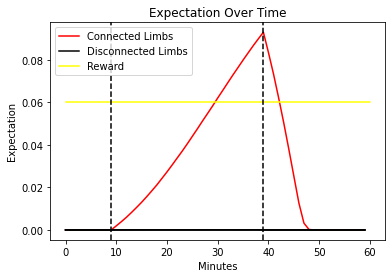

In [ ]:
# plot expectations
plt.plot(mins, rae_mean, 'red', label="Connected Limbs")
plt.plot(mins, lae_mean, "black", label="Disconnected Limbs")
plt.plot(mins, rle_mean, "black")
plt.plot(mins, lle_mean, "black")
plt.plot([0, 60], [reward, reward], "yellow", label="Reward")
plt.xlabel("Minutes")
plt.ylabel("Expectation")
plt.title("Expectation Over Time")

for loc in list(connection_changes):
      av_loc = (last_loc + loc)/2
      last_loc = loc
      prev_connected = not prev_connected
      plt.axvline(loc, color='black', linestyle='dashed')

plt.legend()
plt.show()

# Expectation Over Time
From the graph above, we can see that expectation begins to rise as soon as
the limb is connected. At about minute thirty, expectation surpasses the reward
value, causing a decrease in limb movements. However, once the reward is no 
longer attainable during the disconnect phase, expectation for a reward begins 
to increase limb movements as the infant tries to regain the lost reward.